In [1]:
import os
import json
import numpy as np
import argparse
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import japanese_clip as ja_clip
from transformers import MLukeTokenizer, LukeModel

In [2]:
class BokeJudgeModel(nn.Module):
    def __init__(self, cif_dim = 512, csf_dim = 512, lsf_dim = 768, feature_dim = 1024):
        """
            cif_dim: CLIPの画像の特徴量の次元数
            csf_dim: CLIPの文章の特徴量の次元数
            lsf_dim: Sentene-LUKEの文章の特徴量の次元数
        """
        super(BokeJudgeModel, self).__init__()
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, feature_dim)
        self.fc2 = nn.Linear(feature_dim, feature_dim)
        self.fc3 = nn.Linear(feature_dim, feature_dim)
        self.output_layer = nn.Linear(feature_dim, 1)
        
    def forward(self, cif, csf, lsf):
        """
            cif: CLIPの画像の特徴量
            csf: CLIPの文章の特徴量
            lsf: Sentence-LUKEの文章の特徴量
        """
        x = torch.cat([cif, csf, lsf], dim = 1)

        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        output = torch.sigmoid(self.output_layer(x))
        return output

class SentenceLukeJapanese:
    def __init__(self, device = None):
        self.tokenizer = MLukeTokenizer.from_pretrained("sonoisa/sentence-luke-japanese-base-lite")
        self.model = LukeModel.from_pretrained("sonoisa/sentence-luke-japanese-base-lite",
                                               torch_dtype = torch.float16)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size = 256):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest",
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        return torch.stack(all_embeddings)

class BokeJugeAI:
    def __init__(self, weight_path, feature_dim):
        """
            weight_path: 大喜利適合判定モデルの学習済みの重みのパス
        """
        # 大喜利適合判定AIの読み込み
        self.boke_judge_model = BokeJudgeModel(feature_dim = feature_dim)
        self.boke_judge_model.load_state_dict(torch.load(weight_path))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.boke_judge_model.to(self.device)
        self.boke_judge_model.eval()

        # CLIP
        self.clip_model, self.clip_preprocesser = ja_clip.load("rinna/japanese-clip-vit-b-16",
                                             cache_dir="/tmp/japanese_clip",
                                             torch_dtype = torch.float16,
                                             device = self.device)
        self.clip_tokenizer = ja_clip.load_tokenizer()

        # Sentence-LUKE
        self.luke_model = SentenceLukeJapanese()

    def __call__(self, image_path, sentence):
        """
            image_path: 判定したい大喜利のお題画像
            sentence: 判定したい大喜利
        """
        # CLIPによる特徴量への変換
        tokenized_sentences = ja_clip.tokenize(
            texts = [sentence],
            max_seq_len = 77,
            device = self.device,
            tokenizer = self.clip_tokenizer,
            )
        image = Image.open(image_path)
        preprcessed_image = self.clip_preprocesser(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            clip_image_features = self.clip_model.get_image_features(preprcessed_image)
            clip_sentence_features = self.clip_model.get_text_features(**tokenized_sentences)

        # Sentence-LUKEによる特徴量への変換
        luke_sentence_feature = self.luke_model.encode([sentence])

        # 大喜利適合判定AIの推論
        with torch.no_grad():
            outputs = self.boke_judge_model(clip_image_features,
                                        clip_sentence_features,
                                        luke_sentence_feature.to(self.device))

        return outputs.cpu().numpy()

In [3]:
boke_judge_AI = BokeJugeAI(weight_path = "/home/user/workspace/Master_Thesis/results/Boke_Judge/False_False_False_True_True_1_15_64_0.0001_1024/best_model.pth", 
                           feature_dim = 1024)

<ipython-input-2-25a8a327134a>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.boke_judge_model.load_state_dict(torch.load(weight_path))


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/workspace/Master_Thesis/results/Boke_Judge/False_False_False_True_True_1_15_64_0.0001_1024/best_model.pth'

In [5]:
with open("generated_ohgiri.json", "r") as f:
    generated_ohgiri = json.load(f)

In [9]:
methods = [
    "human",
    "caption",
    "Neural_Joking_Machine",
    "GUMI_AE",
    "GUMI_AMAE_1.0",
    "GUMI_AMAE_10.0",
    "GUMI_AMAE_100.0",
    "GUMI_AMAE_1000.0",
    "GUMI_AMAE_10000.0",
    "GUMI_T_3"
]

IMAGE_DIR = "../../datas/boke_image/"

In [12]:
for M in methods:
    
    preds = list()
    for O in tqdm(generated_ohgiri):
        image_path = f"{IMAGE_DIR}{O['image_number']}.jpg"
        pred = boke_judge_AI(image_path, O[M])
        preds.append(pred)

    print(M)
    print(np.average(preds), np.var(preds))
    print("=" * 10)

100%|██████████| 200/200 [00:04<00:00, 48.78it/s]


human
0.66973084 0.041310646


100%|██████████| 200/200 [00:03<00:00, 53.27it/s]


caption
0.008578465 0.0043417197


100%|██████████| 200/200 [00:03<00:00, 52.58it/s]


Neural_Joking_Machine
0.5563391 0.06729085


100%|██████████| 200/200 [00:03<00:00, 53.66it/s]


GUMI_AE
0.43245643 0.061992027


100%|██████████| 200/200 [00:03<00:00, 52.33it/s]


GUMI_AMAE_1.0
0.48513505 0.07024258


100%|██████████| 200/200 [00:03<00:00, 54.61it/s]


GUMI_AMAE_10.0
0.4163568 0.038962036


100%|██████████| 200/200 [00:03<00:00, 52.18it/s]


GUMI_AMAE_100.0
0.45307162 0.05997465


100%|██████████| 200/200 [00:03<00:00, 53.03it/s]


GUMI_AMAE_1000.0
0.4772019 0.06377521


100%|██████████| 200/200 [00:03<00:00, 52.51it/s]


GUMI_AMAE_10000.0
0.43219215 0.050536383


100%|██████████| 200/200 [00:03<00:00, 52.48it/s]

GUMI_T_3
0.6949591 0.058050375


In [16]:
preds_high = list()
preds_low = list()
preds = list()
stars = list()
for O in tqdm(generated_ohgiri):
    image_path = f"{IMAGE_DIR}{O['image_number']}.jpg"
    pred = boke_judge_AI(image_path, O["human"])
    
    if O["star"] > 10:
        preds_high.append(pred)
    else:
        preds_low.append(pred)

    preds.append(pred)
    stars.append(O["star"])

print(np.average(preds_high), np.var(preds_high))
print(np.average(preds_low), np.var(preds_low))

100%|██████████| 200/200 [00:04<00:00, 47.47it/s]

0.6855812 0.04377045
0.6538805 0.03834836


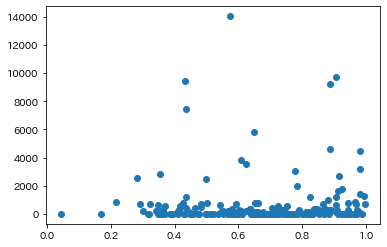

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(preds, stars)